<a href="https://colab.research.google.com/github/biggiefats/HackerNewsAnalysis/blob/main/HackerNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YCombinator Hacker News Analysis
**Querying the Y Combinator's Hacker News API via GCP and SQL.**

### What is the Y Combinator's Hacker News?
The Hacker News dataset is a collection of data from Y Combinator's Hacker News website (news.ycombinator.com).
The dataset was made in 2016 and was last updated in 2022.
This dataset includes all the posts on the website, comments, threads and overall reception.

### Tools Used
- GCP / Google BigQuery / Google Colab
- SQL
- Python / Jupyter Notebooks
- Data Science / Machine Learning

In [ ]:
!pip install --upgrade google-cloud-bigquery

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authentication successful.")

In [3]:
# Choosing SQL-Land Project
ID = 'sql-land-443122'

In [4]:
from google.cloud import bigquery
import pandas as pd

# Establish connection
client = bigquery.Client(project=ID)

## (1) Top 10 Posts, By Comments

Let's find the **top 10** posts, by their comment count.



In [12]:
query = """
SELECT
  title,
  COUNT(descendants) AS comment_count
FROM
  `bigquery-public-data.hacker_news.full`
GROUP BY
  title
ORDER BY
  comment_count DESC
LIMIT
  10;
"""
query_request = client.query(query=query)

In [13]:
df = query_request.to_dataframe()
print(df)

                                    title  comment_count
0               Y Combinator: Bookmarklet            644
1                                  Google            208
2     Http://www.addthis.com/bookmark.php            138
3              Mozilla Firefox Start Page            124
4                             Placeholder            106
5                                Facebook             87
6                    Hacker News | Submit             67
7                         How To Download             55
8                                    Test             51
9  HACK your cell phone Get free internet             49


The top 10 titles seem to **variate**.

*Google* and *Facebook* are 2nd and 6th respectively, and they are both top companies for people in tech.

*Test* and *Placeholder* seem to be stories that are just
used to test the function of a story.

The last one seems a bit odd, because it does not follow
the title casing, and has a unreliable title - *HACK your cell phone Get free internet* - I wouldn't trust that!

### (1.1) How Do the Comments Scale Down?

Let's see if there is a **trend** in how the comment count goes **down**, for the top **100** stories.

In [15]:
# Data visualisation and engineering, if needed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

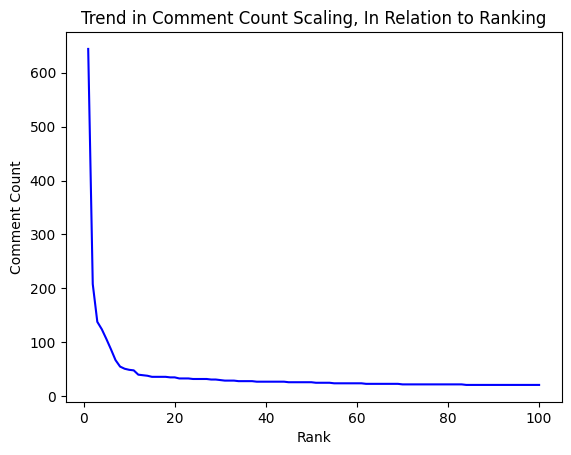

In [17]:
# Request
query = """
SELECT
  title,
  COUNT(descendants) AS comment_count
FROM
  `bigquery-public-data.hacker_news.full`
GROUP BY
  title
ORDER BY
  comment_count DESC
LIMIT
  100;
"""
query_request = client.query(query=query)
df = query_request.to_dataframe()

# Getting data
x = df.index + 1
y = df['comment_count']

# Visualise
fig, ax = plt.subplots()
ax.set_title("Trend in Comment Count Scaling, In Relation to Ranking")
ax.set_xlabel("Rank")
ax.set_ylabel("Comment Count")
ax.plot(x, y, color='blue')
plt.show()

The shape of the graph we have here resembles an **elbow**.
Or, it would resemble the function

$$f(x) \mapsto \frac{1}{x}$$

Surprisingly, we find **Zipf's Law** appear.

---

**Zipf's Law** states that for a **large dataset**, the frequency of the $i$-th most frequent item, denoted as $f(i)$, is
approximately given by:

$$f(i) \sim \frac{C}{i^s}$$
where:
- $f(i)$ is the **frequency** of the $i$-th most frequent item
- $C$ is a constant that **normalizes** the distribution
- $i$ is the **rank** of the item (with 1 being the most frequent)
- $s$ is the **Zipf exponent**, typically close to 1 for many real-world datasets (though it can vary)

Thus, Zipf's Law suggests that the most frequent item occurs roughly twice as often as the second most frequent, three times as often as the third most frequent, and so on. This means the frequency of an event decreases rapidly as the rank increases, following a **power-law distribution**.

---
For our purposes, we assume $s$ to be $1$.

In [43]:
# Linear Regression helpers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

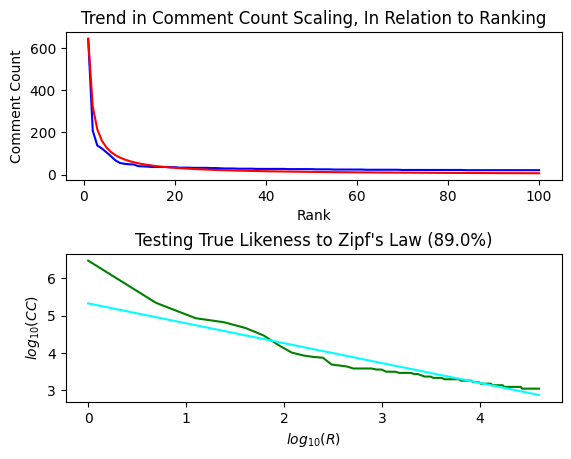

In [52]:
x = df.index + 1
y = df['comment_count']
# plotting 1/x
x2 = np.arange(1, 101)
y2 = y.values[0] / (x2)
# log both x and y, hoping to get straight line
logx = np.log(x)
logy = np.log(y)
LOGX = logx.values.reshape(-1,1)

# Regression
model = LinearRegression()
model.fit(LOGX, logy)
a = model.intercept_
b = model.coef_
eq = a + b * logx
accuracy = round(model.score(LOGX, logy), 2) * 100

# Visualisation
fig, axes = plt.subplots(nrows=2)
ax = axes[0]
ax.set_title("Trend in Comment Count Scaling, In Relation to Ranking")
ax.set_xlabel("Rank")
ax.set_ylabel("Comment Count")
ax.plot(x, y, color='blue')
ax.plot(x2, y2, color='red')

ax = axes[1]
ax.set_title(f"Testing True Likeness to Zipf's Law ({accuracy}%)")
ax.set_xlabel(r"$log_{10}(R)$")
ax.set_ylabel(r"$log_{10}(CC)$")
ax.plot(logx, logy, color='green')
ax.plot(logx, eq, color='aqua')

plt.subplots_adjust(hspace=0.5)

plt.show()

Yet it may not look like it on the bottom figure, the trend shown by story ranking to comment count fits Zipf's Law quite well, with **89%** accuracy.

## (2) Dead or Alive

Let's see what posts are **dead** in the dataset, and their **average vote count.**

What can be presumed by **dead** is that there is low/no traffic to the post.


In [53]:
# Request
query = """
SELECT
  COUNT(title) AS number_of_stories,
  ROUND(AVG(score), 1) AS mean_score,
  dead
FROM
  `bigquery-public-data.hacker_news.full`
WHERE
  dead = TRUE
GROUP BY
  dead;
"""
query_request = client.query(query=query)
df = query_request.to_dataframe()
print(df)

   number_of_stories  mean_score  dead
0             849192         1.4  True


**All** the 849,000+ stories are **dead**, which would mean that this dataset is **outdated**, and cannot be compared to today.

The average score for all of these stories is **1.4**, suggesting that a lot of stories did **not** have a good post reach.